
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [4]:
import pandas as pd
import numpy as np

url = "https://github.com/lvzeyu/chss_2025_assignment/raw/refs/heads/main/%E6%9C%80%E7%B5%82%E8%AA%B2%E9%A1%8C/Data/income_district.csv"
income_df = pd.read_csv(url)
print(income_df.head())

income
   area_code  income_mean
0      13228   480.984419
1      43514   439.775281
2      23237   487.507769
3      18208   505.495103
4      12238   385.423846


In [9]:
url = "https://github.com/lvzeyu/chss_2025_assignment/raw/refs/heads/main/%E6%9C%80%E7%B5%82%E8%AA%B2%E9%A1%8C/Data/h27_work_status_df.csv"
work_df = pd.read_csv(url)
print(work_df.head())

   district_id  district2_id  level_identifier state_name city_name  \
0        37201           NaN                 1        香川県       高松市   
1        37201          10.0                 2        香川県       高松市   
2        37201          20.0                 2        香川県       高松市   
3        37201          30.0                 2        香川県       高松市   
4        37201        3000.0                 3        香川県       高松市   

  district_name district2_name employer_male self_employed_male  \
0           NaN            NaN         91038              11731   
1           塩屋町            NaN            30                  7   
2           築地町            NaN           144                 25   
3           塩上町            NaN           284                 53   
4           塩上町            NaN            14                  5   

  family_work_male unkonwn_status_male employer_female self_employed_female  \
0              957                2525           75462                 3823   
1           

In [10]:
#データ整形
# ↓ 文字列の "-" や NaN を 0 に置き換え、数値型に変換
columns_to_clean = [
    "employer_male", "self_employed_male", "family_work_male", "unkonwn_status_male",
    "employer_female", "self_employed_female", "family_work_female", "unkonwn_status_female"]

for col in columns_to_clean:
    work_df[col] = work_df[col].replace(['-', '－', '―', 'ー', '△', ' '], "0")  # ハイフンを0に
    work_df[col] = pd.to_numeric(work_df[col], errors='coerce').fillna(0).astype(int)

# ↓ 男女合算の列を追加
work_df["employer_total"] = work_df["employer_male"] + work_df["employer_female"]
work_df["self_employed_total"] = work_df["self_employed_male"] + work_df["self_employed_female"]
work_df["family_work_total"] = work_df["family_work_male"] + work_df["family_work_female"]
work_df["unknown_status_total"] = work_df["unkonwn_status_male"] + work_df["unkonwn_status_female"]

# ↓ 合計就業者数
work_df["total_workers"] = (
    work_df["employer_total"] + work_df["self_employed_total"] +
    work_df["family_work_total"] + work_df["unknown_status_total"])

# ↓ 地域名結合カラム（他データと合わせやすく）
work_df['region_name'] = (
    work_df['state_name'] +
    work_df['city_name'] +
    work_df['district_name'].fillna('') +
    work_df['district2_name'].fillna(''))

# ↓ 必要な列だけ残す（他データと結合しやすい形式に）（男女の区別は小地域の収入予想には関係しなさそう）
final_work_df = work_df[[
    'district_id', 'district2_id', 'region_name',
    'employer_total', 'self_employed_total', 'family_work_total',
    'total_workers']]

print(final_work_df.head())

   district_id  district2_id region_name  employer_total  self_employed_total  \
0        37201           NaN      香川県高松市          166500                15554   
1        37201          10.0   香川県高松市塩屋町              56                    9   
2        37201          20.0   香川県高松市築地町             260                   41   
3        37201          30.0   香川県高松市塩上町             496                   77   
4        37201        3000.0   香川県高松市塩上町              30                    7   

   family_work_total  total_workers  
0               5166         191429  
1                  4             70  
2                 11            325  
3                 22            619  
4                  3             42  


In [12]:
url = "https://github.com/lvzeyu/chss_2025_assignment/raw/refs/heads/main/%E6%9C%80%E7%B5%82%E8%AA%B2%E9%A1%8C/Data/h27_age_df.csv"
age_df = pd.read_csv(url)
print(age_df.head())

   district_id  district2_id  level_identifier state_name city_name  \
0        45201           NaN                 1        宮崎県       宮崎市   
1        45201          10.0                 2        宮崎県       宮崎市   
2        45201        1001.0                 3        宮崎県       宮崎市   
3        45201        1002.0                 3        宮崎県       宮崎市   
4        45201        1003.0                 3        宮崎県       宮崎市   

  district_name district2_name  10-14  15-19  20-24  ... 55-59_female  \
0           NaN            NaN  19220  20777  17510  ...        13420   
1           橘通西            NaN     32     56     61  ...           35   
2           橘通西            １丁目      9      6     11  ...           15   
3           橘通西            ２丁目      2     10     18  ...            4   
4           橘通西            ３丁目      -      1      -  ...            1   

  60-64_female 65-69_female 70-74_female 75-79_female 80-84_female  \
0        15035        16040        11697        10052         91

In [13]:
#データ整形
# 数値に変換すべき列を自動抽出（年齢カラムだけ）
age_cols = age_df.columns[7:]  # 最初の7列は識別子系

# ハイフンや空白を0にして、文字列を整数に変換
for col in age_cols:
    age_df[col] = age_df[col].replace(['-', '－', '―', 'ー', '△', ' '], '0')  # ハイフンなどを0に
    age_df[col] = pd.to_numeric(age_df[col], errors='coerce').fillna(0).astype(int)

# 全人口の合計（男性+女性）を合算
age_df['total_population'] = age_df[age_cols].sum(axis=1)

# 女性カラムだけ合算
female_cols = [col for col in age_cols if 'female' in col]
age_df['female_population'] = age_df[female_cols].sum(axis=1)

# 地域コードが float（NaNあり）になってるので整数化
age_df['district2_id'] = age_df['district2_id'].fillna(0).astype(int).astype(str).str.zfill(4)

# 地域名の統一表記
age_df['full_district'] = age_df['state_name'] + age_df['city_name'] + age_df['district_name'].fillna('') + age_df['district2_name'].fillna('')

drop_cols = ['state_name', 'city_name', 'district_name', 'district2_name']
age_df = age_df.drop(columns=drop_cols)
print(age_df.head())

   district_id district2_id  level_identifier  10-14  15-19  20-24  25-29  \
0        45201         0000                 1  19220  20777  17510  18611   
1        45201         0010                 2     32     56     61     60   
2        45201         1001                 3      9      6     11     10   
3        45201         1002                 3      2     10     18     12   
4        45201         1003                 3      0      1      0      0   

   30-34  35-39  40-44  ...  70-74_female  75-79_female  80-84_female  \
0  22131  26144  29081  ...         11697         10052          9160   
1     64     74     99  ...            44            20            16   
2     23     16     23  ...            14             7             7   
3      7     19     14  ...            14             2             2   
4      0      0      0  ...             2             0             1   

   85-89_female  90-94_female  95-99_female  100_female  total_population  \
0          6430      

In [7]:
#3つのデータを結合
final_work_df['district_id'] = final_work_df['district_id'].astype(int).astype(str)
final_work_df['district2_id'] = final_work_df['district2_id'].fillna(0).astype(int).astype(str)

age_df['district_id'] = age_df['district_id'].astype(int).astype(str)
age_df['district2_id'] = age_df['district2_id'].fillna(0).astype(int).astype(str)

income_df['area_code'] = income_df['area_code'].astype(str)

# 地域コードの作成
final_work_df['area_code'] = final_work_df['district_id'] + final_work_df['district2_id']
age_df['area_code'] = age_df['district_id'] + age_df['district2_id']

# work_status と age をマージ
merged_df = pd.merge(
    final_work_df,
    age_df,
    on='area_code',
    how='inner',
    suffixes=('_work', '_age')
)

print("final_work_status + age merge:", merged_df.shape)

# さらに income とマージ
final_df = pd.merge(
    merged_df,
    income_df,
    on='area_code',
    how='inner'
)

print("Final merged shape:", final_df.shape)

# データ確認
print(final_df.head())

/tmp/ipython-input-2642120230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_work_df['district_id'] = final_work_df['district_id'].astype(int).astype(str)
/tmp/ipython-input-2642120230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_work_df['district2_id'] = final_work_df['district2_id'].fillna(0).astype(int).astype(str)
/tmp/ipython-input-2642120230.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

final_work_status + age merge: (252306, 75)
Final merged shape: (8, 76)
  district_id_work district2_id_work  region_name  employer_total  \
0             2321                 0  青森県西津軽郡鰺ヶ沢町            3291   
1             2323                 0   青森県西津軽郡深浦町            2574   
2             1221                 0       北海道名寄市           11787   
3             1222                 0       北海道三笠市            2968   
4             1223                 0       北海道根室市           10479   

   self_employed_total  family_work_total  total_workers area_code  \
0                  779                594           4672     23210   
1                  750                340           3670     23230   
2                 1277                934          14377     12210   
3                  259                161           3400     12220   
4                 1625               1577          13876     12230   

  district_id_age district2_id_age  ...  75-79_female  80-84_female  \
0            2321    

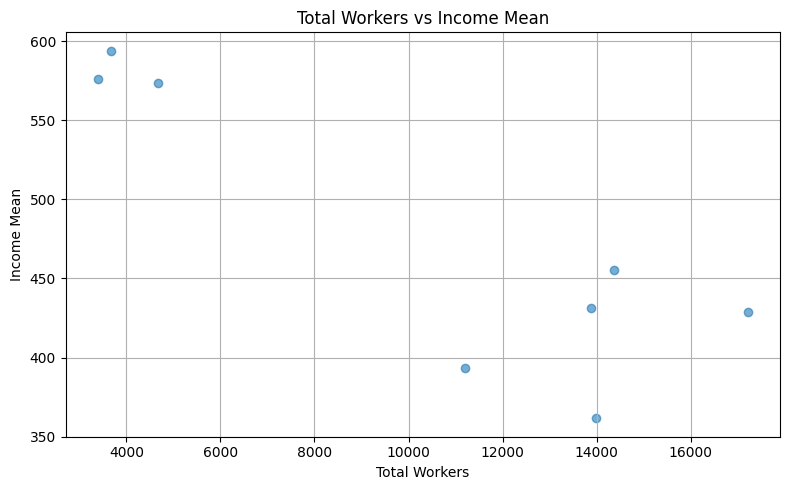

In [8]:
#可視化①　総労働者と収入の関係
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.scatter(final_df['total_workers'], final_df['income_mean'], alpha=0.6)
plt.xlabel('Total Workers')
plt.ylabel('Income Mean')
plt.title('Total Workers vs Income Mean')
plt.grid(True)
plt.tight_layout()
plt.show()


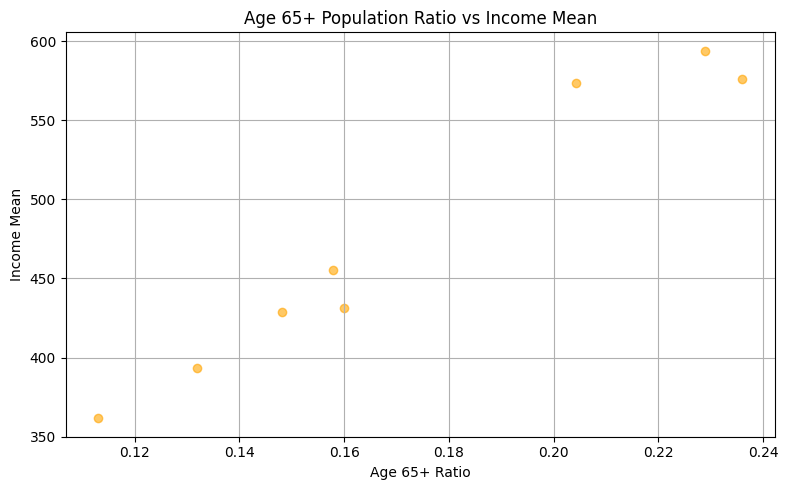

In [18]:
#可視化②　高齢者人口比と収入の関係
final_df['age_65plus_ratio'] = (
    final_df['65-69'] + final_df['70-74'] +
    final_df['75-79'] + final_df['80-84'] +
    final_df['85-89'] + final_df['90-94'] +
    final_df['95-99'] + final_df['100']) / final_df['total_population']

plot_df = final_df[['age_65plus_ratio', 'income_mean']].dropna()

plt.figure(figsize=(8, 5))
plt.scatter(plot_df['age_65plus_ratio'], plot_df['income_mean'], alpha=0.6, color='orange')
plt.xlabel('Age 65+ Ratio')
plt.ylabel('Income Mean')
plt.title('Age 65+ Population Ratio vs Income Mean')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 数値列のみ抽出
num_df = final_df.select_dtypes(include=[np.number])

# 欠損値処理
num_df = num_df.fillna(0)

# 説明変数と目的変数
X = num_df.drop(columns=['income_mean'])
y = num_df['income_mean']

# 学習用・テスト用分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 4つのモデルを用意
models = {"LinearRegression": LinearRegression() ,
    "DecisionTree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5)}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results[name] = {"RMSE": rmse, "R2": r2}

results_df = pd.DataFrame(results).T
print(results_df)


                       RMSE        R2
LinearRegression  41.560921  0.747574
DecisionTree      22.869165  0.923570
RandomForest      23.626402  0.918425
KNeighbors        90.271956 -0.190884


In [ ]:
#4つのモデルを比較したところ、DecisionTree（RMSE=22.87, R²=0.9236）とRandomForest（RMSE=23.63, R²=0.9184）が最も良い性能を示した。
#KNeighborsはRMSEが大きく、今回のデータには適合しなかった。


#モデルの精度を向上させるため、人口や労働者数などの絶対値を、その地域の総人口で割った比率に変換した。
#例：労働力率（総労働者数 ÷ 総人口）、高齢者比率（65歳以上人口 ÷ 総人口）、就業形態構成比（雇用者比、自営業比、家族従業者比）、性比（女性人口 ÷ 総人口）
#これにより、地域ごとの規模の差を除き、構造的な違いをモデルが学習しやすくなった。


#決定木とランダムフォレストは非線形な関係や特徴量間の相互作用を捉えることができ、人口構成や労働構成と収入の複雑な関係を表現できるため、精度が高かった。
#特にランダムフォレストは過学習を抑制でき、汎用性が高いため最終モデルとして選定した。